# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista
- Rafael de Oliveira Évora
- Vinicius Gabriel 

### Carregamento dos dados

In [9]:
import pandas 
import numpy as np

STOCK_NAME = 'EMBR3'

df = pandas.read_csv(f'data/final/{STOCK_NAME}.csv', index_col='DATA', sep=';', decimal='.')
df

,ABERTURA,FECHAMENTO,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME,SELIC
DATA,,,,,,,
17/11/2022,0.1402,0.1389,0.09659,0.1332,0.1422,0.23056,0.050788
18/11/2022,0.1392,0.1420,0.10223,0.1386,0.1463,0.14260,0.050788
21/11/2022,0.1434,0.1436,0.10113,0.1408,0.1450,0.08383,0.050788
22/11/2022,0.1440,0.1429,0.09951,0.1404,0.1450,0.07935,0.050788
23/11/2022,0.1420,0.1418,0.09923,0.1409,0.1443,0.09272,0.050788
...,...,...,...,...,...,...,...
08/11/2024,0.5005,0.5379,0.10747,0.4940,0.5528,0.99999,0.041957
11/11/2024,0.5434,0.5565,0.10346,0.5392,0.5601,0.49551,0.041957
12/11/2024,0.5434,0.5413,0.09727,0.5326,0.5600,0.91050,0.041957


### Separação input e target

In [10]:
# input = [(df[i:i+7].values, np.array([df.iat[i+7, 0]])) for i in range(0, df.index.size - 7)]
input = np.array([(df[i:i+7].to_numpy().flatten()) for i in range(0, df.index.size - 7)])
target = np.array([[df.iat[i+7, 0]] for i in range(0, df.index.size - 7)])

n_test = 7

x_train = input[:-n_test]
t_train = target[:-n_test]

x_test = input[-n_test:]
t_test = target[-n_test:]

x_train.shape, t_train.shape, x_test.shape, t_test.shape

((487, 49), (487, 1), (7, 49), (7, 1))

### Treinamento

Error: 0.002233504094749525 - epochs: 10000


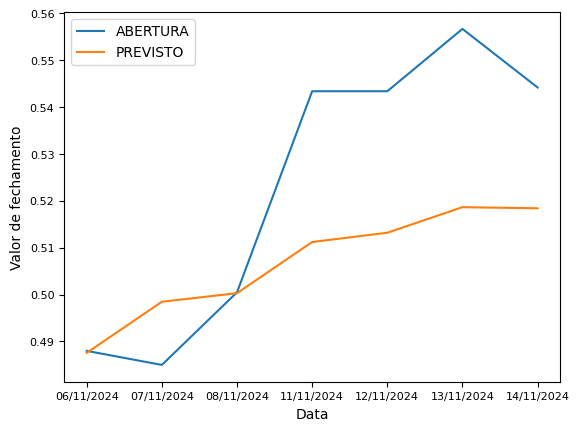

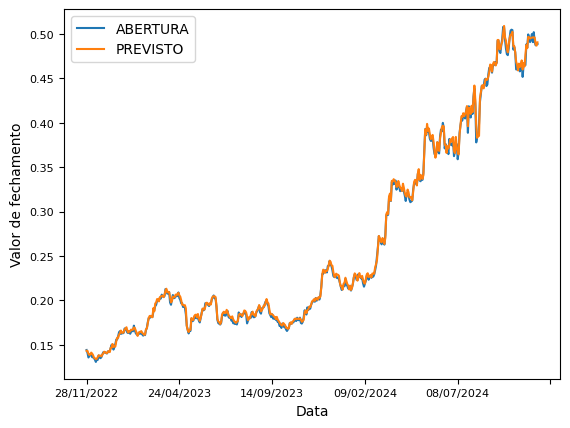

In [11]:
from mlp_model import MLP

mlp = MLP(layers_sizes=[49, 250, 200, 175, 150, 125, 75, 50, 25, 5, 1])
error, epochs = mlp.train(x_train, t_train, learning_rate=0.00125, max_epochs=10000, tolerated_error=0.0001)
print(f'Error: {error} - epochs: {epochs}')

y_test = mlp.predict(x_test)
df_test = df.iloc[-n_test:].copy()
df_test['PREVISTO'] = y_test

df_test.plot(y=['ABERTURA', 'PREVISTO'], xlabel='Data', ylabel='Valor de fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_1(2).png')

y = mlp.predict(x_train)

df_predict = df.iloc[7:-n_test].copy()
df_predict['PREVISTO'] = y

df_predict.plot(y=['ABERTURA', 'PREVISTO'], xlabel='Data', ylabel='Valor de fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_2(2).png')